# Project Part F: All Together Now

![](banner_project.jpg)

In [70]:
analyst = "Khoa Nguyen" # Replace this with your name

In [71]:
f = "setup.R"; for (i in 1:10) { if (file.exists(f)) break else f = paste0("../", f) }; source(f)
options(repr.matrix.max.rows=674)
update_geom_defaults("point", list(size=1))
update_geom_defaults("col", list(fill=PALETTE[1]))
out(5.8,2.1)

## Introduction

### Decision

Recommend a portfolio of 12 company investments that will maximize 12-month profit on a \$1,000,000 investment.

### Approach

Retrieve a public company fundamentals dataset comprising thousands of US companies from quarters 1, 2, 3, and 4 of year 2017 + company stock price data for those companies from quarter 4 of year 2018.

Prepare the data so that each company and its associated information is represented as a single observation.

Apply various descriptive statistics and data visualizations to look for interesting patterns and inter-company relationships.

Transform the dataset using variable filtration, imputation, principal component analysis, and other methods to ready it for predictive model construction.

Build models to predict whether stock price will grow more than 30% over 12 months, given 12 months of past company fundamentals data, using machine learning model construction methods.  Evaluate and tune the models for best business performance.

Build models to predict how much stock price will grow over 12 months, given 12 months of past company fundamentals data, using machine learning model construction methods.  Evaluate and tune the models for best business performance.

Identify the best performing model.

Retrieve an investment opportunities dataset, comprising fundamentals for some set of public companies over some one-year period. Transform the representation of the investment opportunities to match the representation expected by the best performing model, leveraging previous analysis.

Use the best performing model to make predictions about the investment opportunities and accordingly recommend a portfolio of 12 company investments.

### Data Source

Data files:

* Data Dictionary.csv
* Company Fundamentals 2017.csv
* Company Fundamentals 2018.csv

The datasets and accompanying data dictionary are sourced from ...

* Wharton Research Data Services > Compustat - Capital IQ from Standard & Poor's > North America - Daily > Fundamentals Quarterly (https://wrds-www.wharton.upenn.edu/)

  * Date Variable: Data Date
  * Date Range: 2017-01 to 2017-12 -or- 2018-01 to 2018-12
  * Company Codes: Search the entire database
    * Consolidtaion Level: C, Output
    * Industry Format: INDL, FS, Output
    * Data Format: STD, Output
    * Population Source: D, Output
    * Quarter Type: Fiscal View, Output
    * Currency: USD, Output (not CAD)
    * Company Status: Active, Output (not Inactive)
  * Variable Types: Data Items, Select All (674)
  * Query output:
    * Output format: comma-delimited text
    * Compression type: None
    * Data format: MMDDYY10

The datasets are restricted to select US active, publicly held companies that reported quarterly measures including stock prices for 1st, 2nd, 3rd, and 4th quarters in years 2017 and 2018.  All non-missing stock prices exceed $3 per share.  File formats are all comma-separated values (CSV).

The data dictionary is from Variable Descriptions tab, copied to Excel, saved in csv format.

_**For this project, do not source any additional data from year 2019.**_

## Business Model & Business Parameters

The business model is ...

<p style="text-indent: 15px;">
$\begin{align}
& \textsf{profit} = \left( \sum_{i \in \textsf{portfolio}} (1 + \textsf{growth}_i) \times \textsf{allocation}_i \right) - \textsf{budget} \\ \\
& \textsf{profit rate} = \textsf{profit} \div \textsf{budget} \\ \\
& \textsf{budget} = \sum_{i \in \textsf{portfolio}} \textsf{allocation}_i \\ \\
\end{align}$


Business parameters include ...

* $\textsf{budget}$ is total investment to allocate across the companies in the portfolio<br>
* $\textsf{portfolio size}$ is number of companies in the portfolio<br>
* $\textsf{allocation}$ is vector of amounts to allocate to specific companies in the portfolio, must sum to budget
* $\textsf{threshold}$ is growth that qualifies as lowest attractive growth

In [72]:
# Set the business parameters.

budget = 1000000
portfolio_size = 12
allocation = rep(1000000/12, 12) # you can keep or change this setting
threshold = 0.30 # you can keep or change this setting

# x = 1000000 / (12+11+10+9+8+7+6+5+4+3+2+1)
# allocation.1 = c(12*x, 11*x, 10*x, 9*x, 8*x, 7*x, 6*x, 5*x, 4*x, 3*x, 2*x, 1*x) # another of several possible allocations

fmtsx(fmt(budget), fmt(portfolio_size),fmt(allocation), fmt(threshold))

budget 
 
 
 
 
 1,000,000 
 
 
 

 
 

 

 
 
 portfolio_size 
 
 
 
 
 12 
 
 
 

 
 

 

 
 
 allocation 
 
 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 

 
 

 

 
 
 threshold 
 
 
 
 
 0.3

Portfolio to be filled with companies that will maximize profit.

## Data

### Retrieve Raw Data

In [73]:
# Retrieve the 2017 data.
# How many observations and variables?

data.2017 = read.csv("Company Fundamentals 2017.csv", header=TRUE, na.strings=c("NA", ""), stringsAsFactors=FALSE)

fmtx(size(data.2017))

size(data.2017) 
 
 
 observations 
 variables 
 
 
 
 
 33,269 
 680

In [74]:
# Retrieve the 2018 data.
# How many observations and variables?

data.2018 = read.csv("Company Fundamentals 2018.csv", header=TRUE, na.strings=c("NA", ""), stringsAsFactors=FALSE)

fmtx(size(data.2018))

size(data.2018) 
 
 
 observations 
 variables 
 
 
 
 
 35,728 
 680

### Prepare

_2017 Data:_

Partition the dataset by calendar quarter in which information is reported. Filter in observations to include only those with non-missing `prccq` $\geq$ 3.  Then remove any observations about companies that reported more than once per quarter.  Then change all the variable names (except for the `gvkey`, `tic`, and `conm` variables) by suffixing them with quarter information - e.g., in the Quarter 1 dataset, `prccq` becomes `prccq.q1`, etc.  Consolidate the four quarter datasets into one dataset, with one observation per company that includes variables for all four quarters.  Remove any observations with missing `prccq.q4` values.

_2018 Data:_

Filter the dataset by calendar quarter in which information is reported, keeping only observations with information reported in quarter 4. Additionally, filter in observations to include only those with non-missing `prccq`, and keep only the `gvkey` and `prccq` variables.  Then remove any observations about companies that reported more than once per quarter.

_2017/2018 Data:_

Consolidate the processed 2017 dataset and processed 2018 dataset, keeping only observations that have both 2017 and 2018 information.  Then add these 2 synthetic variables:

<p style="text-indent: 15px;">
$\begin{align}
\textsf{growth} & = \left( \textsf{prccq} - \textsf{prccq.q4} \right) \div \textsf{prccq.q4} \\
\textsf{big growth} & = \textsf{growth} \geq \textsf{threshold}
\end{align}$

In [75]:
# Partition the 2017 data.
# Consolidate the 2017 data partitions.
# Filter the 2018 data.
# Consolidate the 2017 data and 2018 data.
# How many observations and variables?

# Partition the 2017 the data.

q = quarter(mdy(data.2017$datadate))

data.current.q1 = data.2017[(q==1) & !is.na(data.2017$prccq) & (data.2017$prccq>=3),]
data.current.q2 = data.2017[(q==2) & !is.na(data.2017$prccq) & (data.2017$prccq>=3),]
data.current.q3 = data.2017[(q==3) & !is.na(data.2017$prccq) & (data.2017$prccq>=3),]
data.current.q4 = data.2017[(q==4) & !is.na(data.2017$prccq) & (data.2017$prccq>=3),]

data.current.q1 = data.current.q1[!duplicated(data.current.q1$gvkey),]
data.current.q2 = data.current.q2[!duplicated(data.current.q2$gvkey),]
data.current.q3 = data.current.q3[!duplicated(data.current.q3$gvkey),]
data.current.q4 = data.current.q4[!duplicated(data.current.q4$gvkey),]

data.current.q1 = rename_with(data.current.q1, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q1")))
data.current.q2 = rename_with(data.current.q2, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q2")))
data.current.q3 = rename_with(data.current.q3, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q3")))
data.current.q4 = rename_with(data.current.q4, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q4")))

# Consolidate the 2017 data partitions.
data.current = merge(data.current.q1, data.current.q2,by=c("gvkey","tic","conm"), all=TRUE, sort=TRUE)
data.current = merge(data.current, data.current.q3,by=c("gvkey","tic","conm"), all=TRUE, sort=TRUE)
data.current = merge(data.current, data.current.q4,by=c("gvkey","tic","conm"), all=TRUE, sort=TRUE)
data.current = data.current[!is.na(data.current$prccq.q4), ]

# Filter the 2018 data.
q = quarter(mdy(data.2018$datadate))
data.future.q4 = data.2018[(q==4) & !is.na(data.2018$prccq), ]
data.future.q4 = data.future.q4[!duplicated(data.future.q4$gvkey), c("gvkey","prccq")]

# Consolidate the 2017 data and 2018 data.
data = merge(data.current, data.future.q4, by="gvkey", all=FALSE)

threshold = 0.3
data$growth = (data$prccq - data$prccq.q4) / data$prccq.q4
data$big_growth = factor(data$growth >= threshold, levels=c(TRUE, FALSE), labels=c("YES", "NO"))

#move big_growth and growth to the front
data = relocate(data, big_growth, growth, prccq) 
fmtx(size(data))


size(data) 
 
 
 observations 
 variables 
 
 
 
 
 4,305 
 2,714

## Exploratory Data Analysis

In [76]:
# Show fraction of observations that are missing price data.
fmtsx(fmt(sum(is.na(data$prccq.q1) | 
        is.na(data$prccq.q2) | 
        is.na(data$prccq.q3) )/nrow(data), 
        "faction of observations with missing price data", blank=TRUE))

faction of observations with missing price data 
 
 
   
 
 
 
 
 0.0857

In [77]:
# Show another interesting descriptive statistic.
# Present some additional interesting descriptive statistics.

cor.1_2_3_4_growth = cor(data[,c("prccq.q1","prccq.q2","prccq.q3","prccq.q4","growth","prccq")]) # correlation

fmtsx(fmt(cor.1_2_3_4_growth, "Correlation between quarters", row.names=TRUE))

Correlation between quarters 
 
 
 
 prccq.q1 
 prccq.q2 
 prccq.q3 
 prccq.q4 
 growth 
 prccq 
 
 
 
 
 prccq.q1 
 1 
 NA 
 NA 
 NA 
 NA 
 NA 
 
 
 prccq.q2 
 NA 
 1 
 NA 
 NA 
 NA 
 NA 
 
 
 prccq.q3 
 NA 
 NA 
 1 
 NA 
 NA 
 NA 
 
 
 prccq.q4 
 NA 
 NA 
 NA 
 1.0000 
 0.0088 
 0.9603 
 
 
 growth 
 NA 
 NA 
 NA 
 0.0088 
 1.0000 
 0.0447 
 
 
 prccq 
 NA 
 NA 
 NA 
 0.9603 
 0.0447 
 1.0000

In [78]:
# Present some additional interesting descriptive statistics.

cov.1_2_3_4_growth = cov(data[,c("prccq.q1","prccq.q2","prccq.q3","prccq.q4","growth","prccq")]) # covariance

fmtsx(fmt(cov.1_2_3_4_growth, "Covariance between quarters", row.names=TRUE))

Covariance between quarters 
 
 
 
 prccq.q1 
 prccq.q2 
 prccq.q3 
 prccq.q4 
 growth 
 prccq 
 
 
 
 
 prccq.q1 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 
 
 prccq.q2 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 
 
 prccq.q3 
 NA 
 NA 
 NA 
 NA 
 NA 
 NA 
 
 
 prccq.q4 
 NA 
 NA 
 NA 
 105,973.371 
 1.3476 
 96,525.580 
 
 
 growth 
 NA 
 NA 
 NA 
 1.348 
 0.2199 
 6.469 
 
 
 prccq 
 NA 
 NA 
 NA 
 96,525.580 
 6.4690 
 95,345.195

In [79]:
# Show another interesting descriptive statistic.
# Present some additional interesting descriptive statistics.
as.data.frame(describe(data[,c("prccq.q1","prccq.q2","prccq.q3","prccq.q4","prccq","growth")]))[,c(
    'mean','sd','median','min','max', 'range')]


mean    sd       median  min     max      range   
prccq.q1 51.8391 295.4245 24.5750  3.0190 14000.00 13996.98
prccq.q2 52.9379 314.5788 24.2600  3.0000 14000.00 13997.00
prccq.q3 54.9956 350.7298 24.9200  3.0000 15500.00 15497.00
prccq.q4 54.7038 325.5355 24.6922  3.0000 14000.00 13997.00
prccq    49.5639 308.7802 20.9800  0.0250 14450.00 14449.98
growth   -0.1186   0.4689 -0.1492 -0.9956    10.24    11.24

In [85]:
# Present some additional interesting descriptive statistics. 
fmtsx(fmt(sum(data$big_growth == "YES")/nrow(data), "faction of observations as big growth", blank=TRUE))

faction of observations as big growth 
 
 
   
 
 
 
 
 0.0836

In [88]:
# Visualize the amount of missing data across variables.
miss.data = data.frame(na_count=as.numeric(summarize_all(data, ~sum(is.na(.)))))
ggplot(miss.data) + geom_col(aes(x=rank(na_count, ties.method="first"), y = na_count), color=PALETTE[1]) +
ggtitle("Variable Information | Missing Data") + xlab("variable # (sorted by completeness)") +
ylab("number of missing values") 

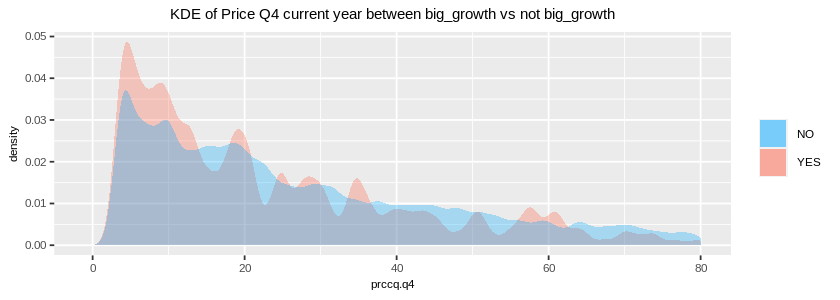

In [89]:
# Show another interesting visualization.
out(7,2.5)
ggplot()+ xlim(-1,80) + 
geom_density(aes(prccq.q4, fill="YES"),data=data[data$big_growth == "YES",], kernel="gaussian", bw=1, alpha = 0.3) +
geom_density(aes(prccq.q4, fill="NO"),data=data[data$big_growth == "NO",], kernel="gaussian", bw=1, alpha = 0.3)+
scale_color_manual(values=c("YES"=PALETTE[1], "NO"=PALETTE[3])) +
ggtitle("KDE of Price Q4 current year between big_growth vs not big_growth")

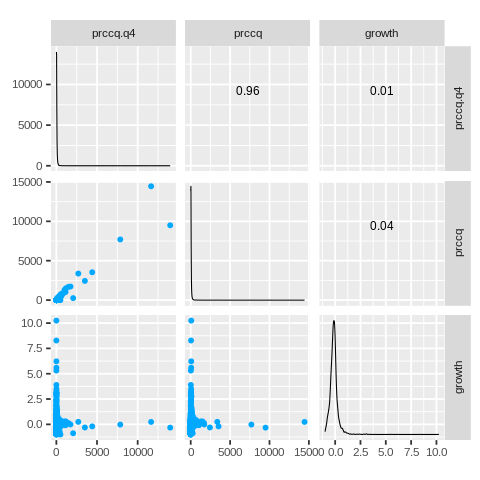

In [90]:
# Present an additional interesting data visualization. 
out(4,4)
ggscatmat(data[,c("prccq.q4","prccq","growth")])

## Data Transformation

Transform data representation:

* Filter the data to include only predictor variables with at least 95% non-missing values.
* Impute missing data ...
  * for each numerical variable, use the mean of non-missing values
  * for each non-numerical variable, use the mode of non-missing values
* Filter the data to include only numerical variables with non-zero variance.
* Transform normalized numerical predictor variables to principal component representation.
* Restore the outcome and identifier variables.
* Filter in outcome and identifier variables, and first three principal components.

In [91]:
# Specify outcome, identifier, and predictor variables.
outvars = colnames(data[1:3]) #big_growth,growth #price(prccq)
idvars = colnames(data[4:6]) #gvkey, tic, conm
prevars = colnames(data[4:ncol(data)]) #excluded outvars

# Filter out sparse variables.
data.filter = select_if(data[, prevars], ~mean(is.na(.)) < 0.05)
cn = colnames(data.filter) #predicted variables --> use later for test data

# Impute missing data.
ml = get_impute(data.filter) ##imputed values --> use later for test data
imputed_data = impute(data.filter)

#filter out observations have 0 variance
data.var = select_if(imputed_data,~is.numeric(.))
data.var = select_if(data.var, ~var(., na.rm=TRUE) != 0)

# Transform numerical predictor variables to principal component representation
pc = prcomp(data.var, scale = TRUE, retx=TRUE)
centroid = pc$center
weight_matrix = pc$rotation
data.pc = as.data.frame(pc$x)

# Restore the outcome and indentifier variables to the data.
data.pcv = cbind(data[, 1:6], data.pc)

# Filter in outcome and identifier variables, and first three principal components.
prevars = colnames(data.pcv[4:9])
data = data.pcv[, 1:9]

# How many observations and variables?
fmtx(size(data))

# Show first few observations of transformed data.
fmtx(data[1:6,], FFO)

size(data) 
 
 
 observations 
 variables 
 
 
 
 
 4,305 
 9

data (first few observations) 
 
 
 big_growth 
 growth 
 prccq 
 gvkey 
 tic 
 conm 
 PC1 
 PC2 
 PC3 
 
 
 
 
 NO 
 0.0507 
 43.69 
 1,004 
 AIR 
 AAR CORP 
 1.4098 
 0.2125 
 -0.1874 
 
 
 NO 
 -0.3829 
 32.11 
 1,045 
 AAL 
 AMERICAN AIRLINES GROUP INC 
 -2.8093 
 0.2246 
 1.4366 
 
 
 YES 
 0.3158 
 6.75 
 1,050 
 CECE 
 CECO ENVIRONMENTAL CORP 
 1.5247 
 0.4396 
 -0.1679 
 
 
 NO 
 -0.2165 
 8.66 
 1,062 
 ASA 
 ASA GOLD AND PRECIOUS METALS 
 1.5737 
 0.6384 
 0.0123 
 
 
 NO 
 -0.1185 
 15.25 
 1,072 
 AVX 
 AVX CORP 
 1.2813 
 0.4529 
 0.0929 
 
 
 NO 
 0.0002 
 85.20 
 1,075 
 PNW 
 PINNACLE WEST CAPITAL CORP 
 0.3698 
 -0.4861 
 -0.0128

## Model 1

Model 1 is a naive Bayes classifier that predicts whether or not a company stock price will grow by 30% or more at 12 months.

In [92]:
# Build, evaluate, and tune a naive Bayes model by iterating through PC1, PC2, PC3 
# predictor variable combinations.
# Show the allocations assumed, predictor variable combination and estimated profit 
# for the searched and best performing models. 

tune = data.frame()
for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="big_growth")) # try every combination of variables
{ 
    nfold = 5
    set.seed(0)
    fold = createFolds(data$big_growth, k=nfold)
    profit = c()
    for (i in 1:nfold) { data.train = data[setdiff(1:nrow(data), fold[[i]]),]
                         data.test  = data[fold[[i]],]
                         model = naiveBayes(big_growth ~ ., data.train[,f], laplace=TRUE)
                         prob = predict(model, data.test, type="raw")
                         class.predicted = as.class(prob, class="YES", cutoff=0.25) #cutoff 0.25
                        
                        data.test$class.predicted = class.predicted
                        data.test$prob = prob[,1]
                        data.sorted = data.test[order(data.test$prob, decreasing=TRUE),]
                        company.data.growth = data.sorted[1:12, "growth"]
                        profit[i] = sum((1 + company.data.growth)*allocation) - budget }

    profit.cv = mean(profit)
    tune = rbind(tune, data.frame(method="naive bayes", variables=vector2string(f), profit.cv))
}

best = tune[which.max(tune$profit.cv),]
fmtsx(fmt(allocation),
     fmt(tune,"search for best model"),
     fmt(best))

allocation 
 
 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 

 
 

 
 search for best model 
 
 
 method 
 variables 
 profit.cv 
 
 
 
 
 naive bayes 
 PC1, big_growth 
 -85,297 
 
 
 naive bayes 
 PC2, big_growth 
 -146,897 
 
 
 naive bayes 
 PC3, big_growth 
 47,492 
 
 
 naive bayes 
 PC1, PC2, big_growth 
 -142,451 
 
 
 naive bayes 
 PC1, PC3, big_growth 
 -116,848 
 
 
 naive bayes 
 PC2, PC3, big_growth 
 -112,989 
 
 
 naive bayes 
 PC1, PC2, PC3, big_growth 
 -79,294 
 
 
 

 
 

 
 best 
 
 
 method 
 variables 
 profit.cv 
 
 
 
 
 naive bayes 
 PC3, big_growth 
 47,492

## Model 2

Model 2 is a linear regression regressor that predicts company growth at 12 months.

In [93]:
# Build, evaluate, and tune a linear regression model by iterating through PC1, PC2, PC3
# predictor variable combinations.
# Show the allocations assumed, predictor variable combination and estimated profit 
# for the searched and best performing models. 

tune = data.frame()
for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="growth")) # try every combination of variables
{ 
    nfold = 5
    set.seed(0)
    fold = createFolds(data$growth, k=nfold)
    profit = c()
    for (i in 1:nfold) {
            data.test  = data[fold[[i]],]
            data.train = data[setdiff(1:nrow(data), fold[[i]]),]
            model_train = lm(growth ~ ., data.train[,f]) 
            growth.predicted = predict(model_train, data.test)
        
            data.test = cbind(data.test,growth.predicted)
            data.test = data.test[order(-data.test$growth.predicted),]
            company.data.growth = data.test[1:12, "growth"]
            profit[i] = sum((1 + company.data.growth)*allocation) - budget }

    profit.cv = mean(profit)    
    tune = rbind(tune, data.frame(method="linreg", variables=vector2string(f), profit.cv))
}
    
best = tune[which.max(tune$profit.cv),]
fmtsx(fmt(allocation),
     fmt(tune,"search for best model"),
     fmt(best))

allocation 
 
 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 

 
 

 
 search for best model 
 
 
 method 
 variables 
 profit.cv 
 
 
 
 
 linreg 
 PC1, growth 
 -288,146 
 
 
 linreg 
 PC2, growth 
 -70,483 
 
 
 linreg 
 PC3, growth 
 -111,428 
 
 
 linreg 
 PC1, PC2, growth 
 -51,470 
 
 
 linreg 
 PC1, PC3, growth 
 -75,214 
 
 
 linreg 
 PC2, PC3, growth 
 -93,628 
 
 
 linreg 
 PC1, PC2, PC3, growth 
 -87,246 
 
 
 

 
 

 
 best 
 
 
 method 
 variables 
 profit.cv 
 
 
 
 
 linreg 
 PC1, PC2, growth 
 -51,470

## Model 3

Using bagging method in two forms: linear regression to predict the company growth at 12 months and naive Bayes classifier to predict whether or not a company stock price will grow by 30% or more at 12 months.

In [94]:
# Build, evaluate, and tune a model with bagging method using linear regression
tune = data.frame()
for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="growth")) # try every combination of variables
{ 
    nfold = 5
    set.seed(0)
    fold = createFolds(data$growth, k=nfold)
    profit = c()
    rmse = c()
        for (i in 1:5)
          { data.test  = data[fold[[i]],]
            data.train = data[setdiff(1:nrow(data), fold[[i]]),]
           
           set.seed(0)
           data.1 = sample_n(data.train,nrow(data.train),replace=TRUE)
           data.2 = sample_n(data.train,nrow(data.train),replace=TRUE)
           data.3 = sample_n(data.train,nrow(data.train),replace=TRUE)
           
           
            model.1 = lm(growth ~ ., data.1[,f]) 
           model.2 = lm(growth ~ ., data.2[,f]) 
           model.3 = lm(growth ~ ., data.3[,f]) 
           

            growth.predicted.1 = predict(model.1, data.test)
           growth.predicted.2 = predict(model.2, data.test)
           growth.predicted.3 = predict(model.3, data.test)
           
            
#             class.predicted = as.class(prob, class="YES", cutoff=0.25)
            growth.predicted.total = data.frame(growth.predicted.1,growth.predicted.2,growth.predicted.3)
           growth.predicted = apply(growth.predicted.total,1,max,na.rm=TRUE)
            error = data.test$growth - growth.predicted
            rmse[i] = sqrt(mean(error^2))
            data.test = cbind(data.test,growth.predicted)
            data.test = data.test[order(-data.test$growth.predicted),]
            company.data.growth = data.test[1:12, "growth"]
            profit = sum((1 + company.data.growth)*allocation) - budget }

    rmse.cv = mean(rmse)
    profit.cv = mean(profit)
    profit_rate.cv = profit.cv/budget
    tune = rbind(tune, data.frame(method="bagging linreg", variables=vector2string(f), profit.cv, rmse.cv,profit_rate.cv))
}

best = tune[which.max(tune$profit.cv),]
fmtsx(fmt(allocation),
     fmt(tune,"search for best model"),
     fmt(best))

allocation 
 
 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 

 
 

 
 search for best model 
 
 
 method 
 variables 
 profit.cv 
 rmse.cv 
 profit_rate.cv 
 
 
 
 
 bagging linreg 
 PC1, growth 
 -167,105 
 0.4661 
 -0.1671 
 
 
 bagging linreg 
 PC2, growth 
 -5,714 
 0.4661 
 -0.0057 
 
 
 bagging linreg 
 PC3, growth 
 -51,343 
 0.4662 
 -0.0513 
 
 
 bagging linreg 
 PC1, PC2, growth 
 70,379 
 0.4661 
 0.0704 
 
 
 bagging linreg 
 PC1, PC3, growth 
 -160,998 
 0.4661 
 -0.1610 
 
 
 bagging linreg 
 PC2, PC3, growth 
 -46,127 
 0.4662 
 -0.0461 
 
 
 bagging linreg 
 PC1, PC2, PC3, growth 
 17,961 
 0.4661 
 0.0180 
 
 
 

 
 

 
 best 
 
 
 method 
 variables 
 profit.cv 
 rmse.cv 
 profit_rate.cv 
 
 
 
 
 bagging linreg 
 PC1, PC2, growth 
 70,379 
 0.4661 
 0.0704

In [95]:
# Build, evaluate, and tune a model with bagging method using naiveBayes classification.
tune = data.frame()
for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="big_growth")) # try every combination of variables
{ 
    nfold = 5
    set.seed(0)
    fold = createFolds(data$big_growth, k=nfold)
    profit = c()
        for (i in 1:5)
          { data.test  = data[fold[[i]],]
            data.train = data[setdiff(1:nrow(data), fold[[i]]),]
           
           set.seed(0)
           data.1 = sample_n(data.train,nrow(data.train),replace=TRUE)
           data.2 = sample_n(data.train,nrow(data.train),replace=TRUE)
           data.3 = sample_n(data.train,nrow(data.train),replace=TRUE)
#                                     model = naiveBayes(big_growth ~ ., data.train[,f], laplace=TRUE)
#                          prob = predict(model, data.test, type="raw")
#                          class.predicted = as.class(prob, class="YES", cutoff=0.25) #cutoff 0.25
           
            model.1 = naiveBayes(big_growth ~ ., data.1[,f],laplace=TRUE)
           model.2 = naiveBayes(big_growth ~ ., data.2[,f],laplace=TRUE)
           model.3 = naiveBayes(big_growth ~ ., data.3[,f],laplace=TRUE)

           prob.1 = predict(model.1, data.test, type="raw")[,1]
           prob.2 = predict(model.2, data.test, type="raw")[,1]
           prob.3 = predict(model.3, data.test, type="raw")[,1]
           
#             prob.total = data.frame(prob.1,prob.2,prob.3)
#             prob = apply(prob.total,1,max,na.rm=TRUE)
           prob = (prob.1+ prob.2 + prob.3)/3

            data.test$prob = prob
            data.sorted = data.test[order(data.test$prob, decreasing=TRUE),]
            company.data.growth = data.sorted[1:12, "growth"]
            profit = sum((1 + company.data.growth)*allocation) - budget }

    profit.cv = mean(profit)
    tune = rbind(tune, data.frame(method="bagging naiveBayes", variables=vector2string(f), profit.cv))
}

best = tune[which.max(tune$profit.cv),]
fmtsx(fmt(allocation),
     fmt(tune,"search for best model"),
     fmt(best))


allocation 
 
 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 

 
 

 
 search for best model 
 
 
 method 
 variables 
 profit.cv 
 
 
 
 
 bagging naiveBayes 
 PC1, big_growth 
 -154,520 
 
 
 bagging naiveBayes 
 PC2, big_growth 
 -103,785 
 
 
 bagging naiveBayes 
 PC3, big_growth 
 -231,896 
 
 
 bagging naiveBayes 
 PC1, PC2, big_growth 
 -228,132 
 
 
 bagging naiveBayes 
 PC1, PC3, big_growth 
 -45,996 
 
 
 bagging naiveBayes 
 PC2, PC3, big_growth 
 41,327 
 
 
 bagging naiveBayes 
 PC1, PC2, PC3, big_growth 
 -8,145 
 
 
 

 
 

 
 best 
 
 
 method 
 variables 
 profit.cv 
 
 
 
 
 bagging naiveBayes 
 PC2, PC3, big_growth 
 41,327

## Model 4

Using kknn method in two forms: regression to predict the company growth at 12 months and classifier to predict whether or not a company stock price will grow by 30% or more at 12 months.

In [96]:
# Build, evaluate, and tune a kknn (regression form)

tune = data.frame()
for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="growth")) # try every combination of variables
{ 
    nfold = 5
    set.seed(0)
    fold = createFolds(data$growth, k=nfold)
    profit = c()
    for (i in 1:nfold) { data.train = data[setdiff(1:nrow(data), fold[[i]]),]
                         data.test  = data[fold[[i]],]                    
                        data.test$growth.predicted = kknn(growth ~ ., data.train[,f], data.test, k=3)$fitted.values
                        data.test = data.test[order(-data.test$growth.predicted),]
                        company.data.growth = data.test[1:12, "growth"]
                        profit[i] = sum((1 + company.data.growth)*allocation) - budget }

    profit.cv = mean(profit)
    tune = rbind(tune, data.frame(method="kknn regression",variables=vector2string(f), profit.cv))
}

best = tune[which.max(tune$profit.cv),]
fmtsx(fmt(allocation),
     fmt(tune,"search for best model"),
     fmt(best))

allocation 
 
 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 

 
 

 
 search for best model 
 
 
 method 
 variables 
 profit.cv 
 
 
 
 
 kknn regression 
 PC1, growth 
 166,333 
 
 
 kknn regression 
 PC2, growth 
 -210,049 
 
 
 kknn regression 
 PC3, growth 
 -80,475 
 
 
 kknn regression 
 PC1, PC2, growth 
 242,857 
 
 
 kknn regression 
 PC1, PC3, growth 
 270,131 
 
 
 kknn regression 
 PC2, PC3, growth 
 -91,025 
 
 
 kknn regression 
 PC1, PC2, PC3, growth 
 537,093 
 
 
 

 
 

 
 best 
 
 
 method 
 variables 
 profit.cv 
 
 
 
 
 kknn regression 
 PC1, PC2, PC3, growth 
 537,093

In [97]:
# Build, evaluate, and tune a kknn (classification form) model.
tune = data.frame()
for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="big_growth")) # try every combination of variables
{ 
    nfold = 5
    set.seed(0)
    fold = createFolds(data$big_growth, k=nfold)
    profit = c()
    for (i in 1:nfold) { data.train = data[setdiff(1:nrow(data), fold[[i]]),]
                         data.test  = data[fold[[i]],]
                         prob = kknn(big_growth ~ ., data.train[,f], data.test, k=15)$prob
                         class.predicted = as.class(prob,class="YES", cutoff=0.25) #cutoff 0.25
                        
                        data.test$class.predicted = class.predicted
                        data.test$prob = prob[,1]
                        data.sorted = data.test[order(data.test$prob, decreasing=TRUE),]
                        company.data.growth = data.sorted[1:12, "growth"]
                        profit[i] = sum((1 + company.data.growth)*allocation) - budget }

    profit.cv = mean(profit)
    tune = rbind(tune, data.frame(method="kknn (classification)", variables=vector2string(f), profit.cv))
}

best = tune[which.max(tune$profit.cv),]
fmtsx(fmt(allocation),
     fmt(tune,"search for best model"),
     fmt(best))

allocation 
 
 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 

 
 

 
 search for best model 
 
 
 method 
 variables 
 profit.cv 
 
 
 
 
 kknn (classification) 
 PC1, big_growth 
 -109,305 
 
 
 kknn (classification) 
 PC2, big_growth 
 -21,928 
 
 
 kknn (classification) 
 PC3, big_growth 
 -31,661 
 
 
 kknn (classification) 
 PC1, PC2, big_growth 
 209,258 
 
 
 kknn (classification) 
 PC1, PC3, big_growth 
 124,690 
 
 
 kknn (classification) 
 PC2, PC3, big_growth 
 102,387 
 
 
 kknn (classification) 
 PC1, PC2, PC3, big_growth 
 446,874 
 
 
 

 
 

 
 best 
 
 
 method 
 variables 
 profit.cv 
 
 
 
 
 kknn (classification) 
 PC1, PC2, PC3, big_growth 
 446,874

## Model 5

Model 5 uses stacking method to predicts whether or not a company stock price will grow by 30% or more at 12 months. 

In [98]:
# Build, evaluate, and tune a model using stacking method.
tune=data.frame()
for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="big_growth")) # try every combination of variables
{ 
    nfold = 5
    set.seed(0)
    fold = createFolds(data$big_growth, k=nfold)
    profit = c()
    for (i in 1:nfold) { data.train = data[setdiff(1:nrow(data), fold[[i]]),]
                         data.test  = data[fold[[i]],]
                        #build diff model
                         model.1 = rpart(big_growth ~ ., data.train[,f],method="class",minsplit=3,cp=10,maxdepth=30)
                         model.2 = naiveBayes(big_growth ~ ., data.train[,f], laplace=TRUE)
                         model.3 = kknn(big_growth ~ ., data.train[,f], data.train, k=3)
#                          class.predicted = as.class(prob,class="YES", cutoff=0.6) #cutoff 0.25
                        #prob
                        prob.1 = predict(model.1,data.train, type="prob")
                        prob.2 = predict(model.2, data.train, type="raw")
                        prob.3 = model.3$prob
                        
                        #assign class
                
                        class.predicted.1 = as.class(prob.1, "YES", cutoff = 0.6) #0.6.0.6 =  177625
                        class.predicted.2 = as.class(prob.2, "YES", cutoff = 0.6) #0.25,0.6 = 177625
                        class.predicted.3 = as.class(prob.3, "YES", cutoff = 0.6) #0.25, 0.25 nope #0.25, 0.5= -4444
                        
                        class = data.train$big_growth
                        data.stack = data.frame(class.predicted.1,class.predicted.2,class.predicted.3,class)
                        
                        #test data with multiple model
                        prob.1 = predict(model.1,data.test, type="prob")
                        prob.2 = predict(model.2, data.test, type="raw")
                        prob.3 = kknn(big_growth ~ ., data.train[,f], data.test, k=3)$prob
                        
                        class.predicted.1 = as.class(prob.1, "YES", cutoff = 0.6) 
                        class.predicted.2 = as.class(prob.2, "YES", cutoff = 0.6)
                        class.predicted.3 = as.class(prob.3, "YES", cutoff = 0.6)
                    
                        data.test.stack = data.frame(class.predicted.1, class.predicted.2, class.predicted.3)
                        
                        model = naiveBayes(class ~ class.predicted.1+class.predicted.2 + class.predicted.3 ,data.stack)
                        prob = predict(model, data.test.stack, type="raw")
                        class.predicted = as.class(prob, class="YES", cutoff=0.8) #cutoff 0.5
                        
                        data.test$class.predicted = class.predicted
                        data.test$prob = prob[,1]
                        data.sorted = data.test[order(data.test$prob, decreasing=TRUE),]
                        company.data.growth = data.sorted[1:12, "growth"]
                        profit[i] = sum((1 + company.data.growth)*allocation) - budget }

    profit.cv = mean(profit)
    profit_rate.cv = profit.cv/budget
    tune = rbind(tune, data.frame(method="stacking", variables=vector2string(f), profit.cv,profit_rate.cv))
}


best = tune[which.max(tune$profit.cv),]
fmtsx(fmt(allocation),
     fmt(tune,"search for best model"),
     fmt(best))

allocation 
 
 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 

 
 

 
 search for best model 
 
 
 method 
 variables 
 profit.cv 
 profit_rate.cv 
 
 
 
 
 stacking 
 PC1, big_growth 
 -194,066 
 -0.1941 
 
 
 stacking 
 PC2, big_growth 
 -66,607 
 -0.0666 
 
 
 stacking 
 PC3, big_growth 
 -131,359 
 -0.1314 
 
 
 stacking 
 PC1, PC2, big_growth 
 -150,342 
 -0.1503 
 
 
 stacking 
 PC1, PC3, big_growth 
 177,625 
 0.1776 
 
 
 stacking 
 PC2, PC3, big_growth 
 -8,390 
 -0.0084 
 
 
 stacking 
 PC1, PC2, PC3, big_growth 
 94,678 
 0.0947 
 
 
 

 
 

 
 best 
 
 
 method 
 variables 
 profit.cv 
 profit_rate.cv 
 
 
 
 
 stacking 
 PC1, PC3, big_growth 
 177,625 
 0.1776

## Model 6

Model 6 is a bagging method with kknn(regression form) to predict the company growth at 12 months

In [99]:
# Build, evaluate, and tune a bagging method with kknn (regression form) model.
tune = data.frame()
for (f in exhaustive(names(data[,c("PC1","PC2","PC3")]), keep="growth")) # try every combination of variables
{ 
    nfold = 5
    set.seed(0)
    fold = createFolds(data$growth, k=nfold)
    profit = c()
    rmse =c()
        for (i in 1:5)
          { data.test  = data[fold[[i]],]
            data.train = data[setdiff(1:nrow(data), fold[[i]]),]
           
           data.1 = sample_n(data.train,nrow(data.train),replace=TRUE)
           data.2 = sample_n(data.train,nrow(data.train),replace=TRUE)
           data.3 = sample_n(data.train,nrow(data.train),replace=TRUE)
           
           model.1 = kknn(growth ~ ., data.1[,f], data.test, k=50)
           model.2 = kknn(growth ~ ., data.2[,f], data.test, k=50)
           model.3 = kknn(growth ~ ., data.3[,f], data.test, k=50)
           

            growth.predicted.1 = model.1$fitted.values
           growth.predicted.2 = model.2$fitted.values
           growth.predicted.3 = model.3$fitted.values
           
            
#             class.predicted = as.class(prob, class="YES", cutoff=0.25)
            growth.predicted.total = data.frame(growth.predicted.1,growth.predicted.2,growth.predicted.3)
           growth.predicted = apply(growth.predicted.total,1,max,na.rm=TRUE)
            error = data.test$growth - growth.predicted
            rmse[i] = sqrt(mean(error^2))
        
            data.test = cbind(data.test,growth.predicted)
            data.test = data.test[order(-data.test$growth.predicted),]
            company.data.growth = data.test[1:12, "growth"]
            profit = sum((1 + company.data.growth)*allocation) - budget }

     rmse.cv = mean(rmse)
    profit.cv = mean(profit)
    profit_rate.cv = profit.cv/budget
    tune = rbind(tune, data.frame(method="bagging kknn (regression)", variables=vector2string(f), 
                                  profit.cv,rmse.cv,profit_rate.cv))
}

best = tune[which.max(tune$profit.cv),]
fmtsx(fmt(allocation),
     fmt(tune,"search for best model"),
     fmt(best))


allocation 
 
 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 83,333 
 
 
 

 
 

 
 search for best model 
 
 
 method 
 variables 
 profit.cv 
 rmse.cv 
 profit_rate.cv 
 
 
 
 
 bagging kknn (regression) 
 PC1, growth 
 881,881 
 0.4704 
 0.8819 
 
 
 bagging kknn (regression) 
 PC2, growth 
 -350,288 
 0.4807 
 -0.3503 
 
 
 bagging kknn (regression) 
 PC3, growth 
 -241,497 
 0.4841 
 -0.2415 
 
 
 bagging kknn (regression) 
 PC1, PC2, growth 
 1,244,886 
 0.4666 
 1.2449 
 
 
 bagging kknn (regression) 
 PC1, PC3, growth 
 1,018,221 
 0.4728 
 1.0182 
 
 
 bagging kknn (regression) 
 PC2, PC3, growth 
 16,031 
 0.4760 
 0.0160 
 
 
 bagging kknn (regression) 
 PC1, PC2, PC3, growth 
 1,262,831 
 0.4665 
 1.2628 
 
 
 

 
 

 
 best 
 
 
 method 
 variables 
 profit.cv 
 rmse.cv 
 profit_rate.cv 
 
 
 
 
 bagging kknn (regression) 
 PC1, PC2, PC3, growth 
 1,262,831 
 0.4665 
 1.263

## Investment Opportunities

Test the best performing model on new investment opportunities.

### Retrieve Investment Data

In [100]:
# Retrieve the investment opportunities data.
# How many observations and variables?

data.io = read.csv("Investment Opportunities.csv", header=TRUE, na.strings=c("NA", ""), stringsAsFactors=FALSE)

fmtx(size(data.io))

size(data.io) 
 
 
 observations 
 variables 
 
 
 
 
 918 
 680

### Prepare Investment Data

In [101]:
# Prepare the investment opportunities data as appropriate for transformation.
# How many observations and variables?
q = quarter(mdy(data.io$datadate))

data.current.q1 = data.io[(q==1) & !is.na(data.io$prccq) & (data.io$prccq>=3),]
data.current.q2 = data.io[(q==2) & !is.na(data.io$prccq) & (data.io$prccq>=3),]
data.current.q3 = data.io[(q==3) & !is.na(data.io$prccq) & (data.io$prccq>=3),]
data.current.q4 = data.io[(q==4) & !is.na(data.io$prccq) & (data.io$prccq>=3),]

data.current.q1 = data.current.q1[!duplicated(data.current.q1$gvkey),]
data.current.q2 = data.current.q2[!duplicated(data.current.q2$gvkey),]
data.current.q3 = data.current.q3[!duplicated(data.current.q3$gvkey),]
data.current.q4 = data.current.q4[!duplicated(data.current.q4$gvkey),]

data.current.q1 = rename_with(data.current.q1, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q1")))
data.current.q2 = rename_with(data.current.q2, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q2")))
data.current.q3 = rename_with(data.current.q3, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q3")))
data.current.q4 = rename_with(data.current.q4, ~ifelse(. %in% c("gvkey","tic","conm"), ., paste0(.,".q4")))

# Consolidate the data partitions.
data.current = merge(data.current.q1, data.current.q2,by=c("gvkey","tic","conm"), all=TRUE, sort=TRUE)
data.current = merge(data.current, data.current.q3,by=c("gvkey","tic","conm"), all=TRUE, sort=TRUE)
data.current = merge(data.current, data.current.q4,by=c("gvkey","tic","conm"), all=TRUE, sort=TRUE)
data.current = data.current[!is.na(data.current$prccq.q4), ]

data.ps = data.current[, cn]
data.ps = put_impute(data.ps,ml)

fmtx(size(data.current))


size(data.current) 
 
 
 observations 
 variables 
 
 
 
 
 230 
 2,711

### Transform Investment Data

In [102]:
# Transform the prepared investment dataset as apprpriate for use with the
# best performing model.
# How many observations and variables?
# Show the first few observations of the resulting dataset.
data.pc = predict(pc, data.ps)
data.real = cbind(data.current[, 1:6], data.pc)
data.real = data.real[, prevars]
fmtx(size(data.real))
fmtx(data.real[1:6,],FFO)

size(data.real) 
 
 
 observations 
 variables 
 
 
 
 
 230 
 6

data.real (first few observations) 
 
 
 gvkey 
 tic 
 conm 
 PC1 
 PC2 
 PC3 
 
 
 
 
 1,004 
 AIR 
 AAR CORP 
 1.4196 
 0.0580 
 -0.2577 
 
 
 1,410 
 ABM 
 ABM INDUSTRIES INC 
 1.0563 
 0.0729 
 -0.1602 
 
 
 1,562 
 AMSWA 
 AMERICAN SOFTWARE -CL A 
 1.6304 
 0.3224 
 -0.1279 
 
 
 1,618 
 AXR 
 AMREP CORP 
 0.8877 
 0.1452 
 -0.6410 
 
 
 1,632 
 ADI 
 ANALOG DEVICES 
 -1.6234 
 -0.4854 
 -0.9771 
 
 
 1,686 
 APOG 
 APOGEE ENTERPRISES INC 
 1.4219 
 -0.1529 
 -0.3698

## Apply Model

### Build Best Model

In [103]:
# Build the best performing model using all 2017 and 2018 data for training.
set.seed(0)
data.1 = sample_n(data,nrow(data),replace=TRUE)
data.2 = sample_n(data,nrow(data),replace=TRUE)
data.3 = sample_n(data,nrow(data),replace=TRUE)
           
model.1 = data.1 
model.2 = data.2 
model.3 = data.3 


### Recommend Portfolio

In [104]:
# Use the model to inform the decision about how to fill the portfolio with companies
# from the investment opportunities.
# Show the portfolio: gvkey, tic, conm, allocation

growth.predicted.1 = kknn(growth ~ PC1 + PC2 + PC3, model.1, data.real, k=50)$fitted.values
growth.predicted.2 = kknn(growth ~ PC1 + PC2 + PC3, model.2, data.real, k=50)$fitted.values
growth.predicted.3 = kknn(growth ~ PC1 + PC2 + PC3, model.3, data.real, k=50)$fitted.values

growth.predicted.total = data.frame(growth.predicted.1,growth.predicted.2,growth.predicted.3)
growth.predicted = apply(growth.predicted.total,1,max,na.rm=TRUE)

portfolio = data.real
portfolio$growth.predicted = growth.predicted
portfolio = portfolio[order(-portfolio$growth.predicted),]
portfolio = portfolio[1:12, c("gvkey","tic","conm")]
portfolio$allocation = allocation
fmtx(portfolio)

portfolio 
 
 
 gvkey 
 tic 
 conm 
 allocation 
 
 
 
 
 137,310 
 MRVL 
 MARVELL TECHNOLOGY GROUP LTD 
 83,333 
 
 
 15,520 
 SIG 
 SIGNET JEWELERS LTD 
 83,333 
 
 
 1,562 
 AMSWA 
 AMERICAN SOFTWARE -CL A 
 83,333 
 
 
 28,084 
 COUP 
 COUPA SOFTWARE INC 
 83,333 
 
 
 7,138 
 MAYS 
 MAYS (J.W.) INC 
 83,333 
 
 
 2,818 
 CATO 
 CATO CORP -CL A 
 83,333 
 
 
 2,829 
 RFIL 
 R F INDUSTRIES LTD 
 83,333 
 
 
 9,599 
 SMTC 
 SEMTECH CORP 
 83,333 
 
 
 30,736 
 OKTA 
 OKTA INC 
 83,333 
 
 
 33,232 
 ZUO 
 ZUORA INC 
 83,333 
 
 
 34,055 
 KLXE 
 KLX ENERGY SERVS HLDNG 
 83,333 
 
 
 26,746 
 NTNX 
 NUTANIX INC 
 83,333

### Store Portfolio Recommendation

In [107]:
write.csv(portfolio, paste0(analyst, "-final.csv"), row.names=FALSE)

### Confirm That Format Is Correct

In [108]:
portfolio.retrieved = read.csv(paste0(analyst, "-final.csv"), header=TRUE)
opportunities = unique(read.csv("Investment Opportunities.csv", header=TRUE)$gvkey)

columns = all(colnames(portfolio.retrieved) == c("gvkey", "tic", "conm", "allocation"))
companies = all(portfolio.retrieved$gvkey %in% opportunities)
allocations = round(sum(portfolio.retrieved$allocation)) == budget
                         
check = data.frame(analyst, columns, companies, allocations)
fmtx(check, "Portfolio Recommendation | Format Check")

Portfolio Recommendation | Format Check 
 
 
 analyst 
 columns 
 companies 
 allocations 
 
 
 
 
 Khoa Nguyen 
 TRUE 
 TRUE 
 TRUE

## Discussion

In order to create a portfolio recommending 12 companies with the highest return on profit, understanding the dataset is my first step. I attempt to familiarize myself with the data dictionary, which describes the variables in the dataset, but there are several variables that I don't know the meaning of, so I decided to use principal components to transform the data.

Before applying the principal component transformation, I explore some insights from the consolidated data (after combining 2017 and 2018 data). I observe that the dataset has a low level of missing data and only a small portion of companies with big growth (growth of more than 30%). The data is not balanced in terms of big growth or not. To prepare the data for analysis, I clean it by filtering, imputing missing values, and transforming it using Principal Component Analysis (PCA).

Next, I apply various methods to find the best models. I start by trying linear regression and naive Bayes classification as guidance. I find that the naive Bayes method yields a higher profit, but the amount of profit is still low. In the descriptive analysis, I notice that the maximum growth is only 10%, which is insufficient for achieving the desired return on my budget.

To improve the models, I try the bagging method for both linear regression and naive Bayes classification. Although the results show some improvement, it is not significant. To gain deeper insights, I visualize the relationship between each Principal Component (PC) and growth with color-coding using big_growth. This visualization helps me identify concentrations within the two groups.

Motivated by these observations, I decide to perform cluster analysis using the Gaussian mixture method to group the data into two clusters based on PC1, PC2, and PC3. I aim to identify any trends in the data. I choose methods that have a strong methodology based on the relationships between the nearest points.

One method I try is the k-nearest-neighbor (k-NN) classifier to predict big_growth, which yields a jump in the results. This model works well as I achieve a profit. However, I realize that it predicts whether a company has big growth or not and ranks the companies based on the probability of being in the big growth category, rather than considering the actual growth rate.

To address this limitation, I decide to try the kknn method in regression form, which shows very promising results. Finally, I apply the bagging method on three kknn regression models, where the predicted value is the highest growth among these three model predictions.

Through this project, I have learned the importance of combining cross-validation with business parameters to select the best model. I also consider the sensitivity of each model to the chosen parameters, as my model's performance varies depending on these factors. In the future, I would like to improve my model to be more stable with business parameters or try some more methods to fit this problem.  

I find this project to be very useful and interesting as I can apply different methods and compare their pros and cons based on the data types and business scenarios I encounter.


<p style="text-align:left; font-size:10px;">
Copyright (c) Huntsinger Associates, LLC
<span style="float:right;">
Document revised May 6, 2023
</span>
</p>